In [241]:
import pandas as pd

from IPython.display import display

import visuals as vs
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

# prediction_dt is 1 month ahead of active_as_of_dt and they should be month-ends
def get_customer_status(prediction_dt, active_as_of_dt):
    #df = spark.read.format("csv").option("header", "true").option("delimiter", "\t").load("customer_status_history_train.csv.gz")
    df = pd.read_csv("customer_status_history_train.csv",sep='\t')
    #status = df.filter(df.snapshot_day <= prediction_dt).toPandas()
    status = df[df['snapshot_day']<=prediction_dt]
    status.snapshot_day = pd.to_datetime(status.snapshot_day, format='%Y-%m-%d')
    prior_month = status[status.snapshot_day <= active_as_of_dt].groupby('customer_id')
    # pick the last status of the month
    xr = prior_month.last()

    res = prior_month['snapshot_day'].agg({'enter': 'first', 'exit': 'last'})

    res['time_diff'] = res['exit'] - res['enter']
    
    active_customers = xr[xr.ku_status == 'PAID ACTIVE'].index
    
#     print res.columns.values
    prediction_month = status[status.snapshot_day <= prediction_dt].groupby('customer_id')
    # set the last status of the month (in case the status flipped within the month)
    xr = prediction_month.last()
    
    completedf = pd.merge(xr, res, left_index=True, right_index=True, how="right")

    completedf.time_diff = completedf.time_diff.dt.days
    
    completedf.drop(['enter','exit'], axis=1, inplace=True)
    
    prediction_month_status = completedf[completedf.index.isin(active_customers)]
    
    return prediction_month_status


In [208]:
status = get_customer_status('2017-08-31', '2017-07-31')
status.head(5)

,snapshot_day,ku_status
customer_id,,
00012d5c5b3caba6486bf760f154a1a1310603a87a233982f19365ed4af4b60f,2017-08-10,PAID CANCELLED
000151374577dd6fe194237e23627f83541bcc39926089d7f63bc041c7fafe67,2017-08-24,PAID CANCELLED
00015215c16e4586578b42c2ee8535cbcec8e93bf2b62c78dfcbc059573d58b1,2017-02-01,PAID ACTIVE
000152eaa0928969c1da93e930e2944698e21594729f6ae7182e8cda46233c46,2017-08-20,PAID CANCELLED
0001d4efe1974e3d822ebed0ac4bc05cf85da8a8b61d839a504b9c3d92c4f53b,2017-05-12,PAID ACTIVE


In [188]:
import pandas as pd
def get_customer_activity_features(month_end_dt):
    # Read the purchase history file in
    # ph = spark.read.format("csv").option("header", "true").option("delimiter", "\t").load("customer_purchase_history.csv.gz")
    ph = pd.read_csv("customer_purchase_history.csv",sep='\t')
    data = ph[ph['snapshot_day']==month_end_dt]
    cust_features = data[['customer_id', 'paid_units_mtd', 'ku_loans_t7', 'ku_loans_mtd', 'free_units_mtd', 'pbook_units_mtd']]
    # Cheat by filtering on the month end summary record. Pick only paid units and ku loans month-to-date
    #cust_features = ph.filter(ph.snapshot_day == month_end_dt).select(['customer_id', 'paid_units_mtd', 'ku_loans_t7', 'ku_loans_mtd', 'free_units_mtd', 'pbook_units_mtd']).toPandas()
    # Convert to integer type
    cust_features.paid_units_mtd = cust_features.paid_units_mtd.astype(int)
    cust_features.ku_loans_mtd = cust_features.ku_loans_mtd.astype(int)
    cust_features.ku_loans_t7 = cust_features.ku_loans_t7.astype(int)
    cust_features.free_units_mtd = cust_features.free_units_mtd.astype(int)
    cust_features.pbook_units_mtd = cust_features.pbook_units_mtd.astype(int)
    return cust_features
    # cust_features[(cust_features.paid_units_mtd != 0) & (cust_features.ku_loans_mtd != 0)].count()


In [126]:
frame1 = get_customer_activity_features('2017-07-31')
print frame1.shape
frame1.index = frame1.customer_id
frame1 = frame1.drop('customer_id', axis=1)

frame2 = get_customer_activity_features('2017-06-30')
print frame2.shape

frame2.index = frame2.customer_id
frame2 = frame2.drop('customer_id', axis=1)

frame2.rename(columns={'paid_units_mtd': 'paid_units_mtd_june', 'ku_loans_t7': 'ku_loans_t7_june', 'ku_loans_mtd': 'ku_loans_mtd_june', 'free_units_mtd': 'free_units_mtd_june', 'pbook_units_mtd': 'pbook_units_mtd_june'}, inplace=True)

frame1 = pd.merge(frame1, frame2 , left_index=True, right_index=True, how="outer")
frame1.head(30)
# print frame1.shape
# frame1.fillna(0, inplace=True)

(135985, 6)
(128396, 6)


,paid_units_mtd,ku_loans_t7,ku_loans_mtd,free_units_mtd,pbook_units_mtd,paid_units_mtd_june,ku_loans_t7_june,ku_loans_mtd_june,free_units_mtd_june,pbook_units_mtd_june
customer_id,,,,,,,,,,
00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000e2aee8f9a5f294b1d8f765c8848e00eb051cc4faaa3ab4eb75c879dbcb7b,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
000112ee1dbd72cede2d7e0b62eb010ba97bb6ec12eac83328b545f11c434f2b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00012d5c5b3caba6486bf760f154a1a1310603a87a233982f19365ed4af4b60f,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
000151374577dd6fe194237e23627f83541bcc39926089d7f63bc041c7fafe67,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
00015215c16e4586578b42c2ee8535cbcec8e93bf2b62c78dfcbc059573d58b1,4.0,1.0,1.0,0.0,1.0,3.0,1.0,9.0,1.0,0.0
000152eaa0928969c1da93e930e2944698e21594729f6ae7182e8cda46233c46,0.0,3.0,11.0,3.0,0.0,0.0,0.0,2.0,0.0,1.0
0001b4a4c789ea629a0d2bbf2aa3ae25404dc03ad836d97efb7b83e8b178f46a,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0001d4efe1974e3d822ebed0ac4bc05cf85da8a8b61d839a504b9c3d92c4f53b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
raw_data = {
        'subject_id': ['1', '2', '3', '4', '5'],
        'first_name': ['Alex', 'Amy', 'Allen', 'Alice', 'Ayoung'], 
        'last_name': ['Anderson', 'Ackerman', 'Ali', 'Aoni', 'Atiches']}
df_a = pd.DataFrame(raw_data, columns = ['subject_id', 'first_name', 'last_name'])
df_a.index = df_a.subject_id
df_a = df_a.drop('subject_id', axis=1)
df_a

raw_data = {
        'subject_id': ['4', '5', '6', '7', '8'],
        'second_name': ['Billy', 'Brian', 'Bran', 'Bryce', 'Betty'], 
        'no_name': ['Bonder', 'Black', 'Balwner', 'Brice', 'Btisan']}
df_b = pd.DataFrame(raw_data, columns = ['subject_id', 'second_name', 'no_name'])
df_b.index = df_b.subject_id
df_b = df_b.drop('subject_id', axis=1)
df_b

finalpd = pd.merge(df_a, df_b, right_index=True, left_index=True, how="right")
finalpd.fillna('Vivek', inplace=True)
finalpd

,first_name,last_name,second_name,no_name
subject_id,,,,
4,Alice,Aoni,Billy,Bonder
5,Ayoung,Atiches,Brian,Black
6,Vivek,Vivek,Bran,Balwner
7,Vivek,Vivek,Bryce,Brice
8,Vivek,Vivek,Betty,Btisan


In [189]:
def get_customer_device_features(month_end_dt):
    # Read the device history file in
    # dh = spark.read.format("csv").option("header", "true").option("delimiter", "\t").load("customer_device_history.csv.gz")
    dh = pd.read_csv("customer_device_history.csv",sep='\t')
    data = dh[dh['snapshot_day']<= month_end_dt]
    cust_features = data[['snapshot_day', 'customer_id', 'active_android', 'active_kcp', 'active_ios', 'active_kcr', 'active_tablet', 'active_eink', 'active_phone']]
    # Convert to integer type
    #cust_features.active_android = cust_features.active_android.astype(float)
    
    #cust_features.active_android.fillna(0, inplace=True)
    #cust_features.active_android = cust_features.active_android.astype(int)
    #cust_features = cust_features.groupby('customer_id')['active_android'].last()
    
    #cust_features = pd.Series.to_frame(cust_features)
#     cust_features.head(10)
    cust_features['num_active'] = cust_features.sum(axis=1)
    
    cust_features.num_active = cust_features.num_active.astype(float)
    cust_features.num_active.fillna(0, inplace=True)
    cust_features.num_active = cust_features.num_active.astype(int)
    cust_features = cust_features.groupby('customer_id')['num_active'].last()
    return cust_features
    # cust_features[(cust_features.paid_units_mtd != 0) & (cust_features.ku_loans_mtd != 0)].count()

# device_counts = get_customer_device_features('2017-08-31')
# device_counts.head()

In [190]:
device_counts = get_customer_device_features('2017-07-31')
device_counts.head(3)

customer_id
00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e    2
0000dfb1ac7e6ffb2e8f0f4e14271afa87cf0c5cddc030916709d13ef1763d76    2
0000e2aee8f9a5f294b1d8f765c8848e00eb051cc4faaa3ab4eb75c879dbcb7b    3
Name: num_active, dtype: int32

In [259]:
# Normalize

# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
def getNormalizedFeatures(feas):
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = []
    for feature in feas.keys():
        numerical = numerical + [feature]
    if 'status' in numerical:
        numerical.remove('status')
    if 'Intercept' in numerical:
        numerical.remove('Intercept')
        
#     numerical = ['paid_units_mtd','ku_loans_t7','ku_loans_mtd','free_units_mtd','pbook_units_mtd','paid_units_mtd_june','ku_loans_t7_june','ku_loans_mtd_june','free_units_mtd_june','pbook_units_mtd_june','num_active','time_diff']
#     numerical2 = ['paid_units_mtd_may','ku_loans_t7_may','ku_loans_mtd_may','free_units_mtd_may','pbook_units_mtd_may']
#     numerical3 = ['paid_units_mtd_apr','ku_loans_t7_apr','ku_loans_mtd_apr','free_units_mtd_apr','pbook_units_mtd_apr']
#     numerical = numerical + numerical2 + numerical3
    features_log_minmax_transform = pd.DataFrame(data = feas)
    features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_minmax_transform[numerical])
    return features_log_minmax_transform

# Show an example of a record with scaling applied
features_log_minmax_transform.head(n = 5)

,paid_units_mtd,ku_loans_t7,ku_loans_mtd,free_units_mtd,pbook_units_mtd,paid_units_mtd_june,ku_loans_t7_june,ku_loans_mtd_june,free_units_mtd_june,pbook_units_mtd_june,...,free_units_mtd_may,pbook_units_mtd_may,paid_units_mtd_apr,ku_loans_t7_apr,ku_loans_mtd_apr,free_units_mtd_apr,pbook_units_mtd_apr,status,time_diff,num_active
customer_id,,,,,,,,,,,,,,,,,,,,,
18272f7fb12370c0a3f3f7b199d5d691be231ac491257c4c342611fe5998643b,0.097938,0.00211,0.024802,0.027426,0.095890,0.000000,0.000000,0.000000,0.033382,0.0,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,PAID ACTIVE,0.000000,0.049180
826a38e1a5bcf566411f775491ec3aa0ecd6d7d5f2e8c5cf781c0a1836da5320,0.000000,0.00000,0.001984,0.004219,0.013699,0.014599,0.004902,0.003165,0.001451,0.0,...,0.0,0.007605,0.0,0.00000,0.001603,0.0,0.013699,PAID ACTIVE,0.445293,0.098361
0c0d145bbab185dc3b9940c54e9d26be7da9df116a6b0ff0f4df0a02eba3e20b,0.000000,0.00000,0.000992,0.000000,0.000000,0.000000,0.000000,0.001055,0.000000,0.0,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,PAID ACTIVE,0.386768,0.032787
01278220976bcc9a1efb7bf086e40013b89101f37b1df7060c0867fc33adb4ce,0.010309,0.00000,0.000000,0.000000,0.006849,0.000000,0.000000,0.002110,0.000000,0.0,...,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,PAID ACTIVE,0.631043,0.147541
4ed3507f64b47b9fe6bdc0681367c9085f8d3814dab726373a9542487edda598,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003165,0.000000,0.0,...,0.0,0.000000,0.0,0.01548,0.011218,0.0,0.000000,PAID ACTIVE,0.000000,0.049180


In [234]:
def removeOutliers(features):
    
    features_after_removing_outliers = features.copy()
    for feature in features.keys():

        if feature == 'status':
            continue
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(features[feature],25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(features[feature],75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = (Q3-Q1)*1.5

        # Display the outliers
        #print "Data points considered outliers for the feature '{}':".format(feature)
        features_after_removing_outliers.drop(features[~((features[feature] >= Q1 - step) & (features[feature] <= Q3 + step))].index)
    return features_after_removing_outliers
# OPTIONAL: Select the indices for data points you wish to remove
# outliers  = [75,154,66]

# # Remove the outliers, if any were specified
# good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

In [12]:
# Code to save intermediate data frames to CSV
# from io import BytesIO
# import boto3
# from boto3.session import Session

# # To be used in eider workspace only (references variables provided by eider)
# def write_to_s3(df, bucket, key):
#     session = Session(aws_access_key_id=awsAccessKeyId, aws_secret_access_key=awsSecretKey)
#     s3_resource = session.resource("s3")
#     csv_buffer = BytesIO()
#     df.to_csv(csv_buffer)
#     # s3_resource.Object('emr-eldorado', 'cust_features.csv').put(Body=csv_buffer.getvalue())
#     s3_resource.Object(bucket, username + "/" + key).put(Body=csv_buffer.getvalue())

In [251]:
x = get_customer_activity_features('2017-07-31')
x.index = x.customer_id
x = x.drop('customer_id', axis=1)

y = get_customer_activity_features('2017-06-30')
y.index = y.customer_id
y = y.drop('customer_id', axis=1)

y.rename(columns={'paid_units_mtd': 'paid_units_mtd_june', 'ku_loans_t7': 'ku_loans_t7_june', 'ku_loans_mtd': 'ku_loans_mtd_june', 'free_units_mtd': 'free_units_mtd_june', 'pbook_units_mtd': 'pbook_units_mtd_june'}, inplace=True)

x = pd.merge(x, y , left_index=True, right_index=True, how="outer")

z = get_customer_activity_features('2017-05-31')
z.index = z.customer_id
z = z.drop('customer_id', axis=1)

z.rename(columns={'paid_units_mtd': 'paid_units_mtd_may', 'ku_loans_t7': 'ku_loans_t7_may', 'ku_loans_mtd': 'ku_loans_mtd_may', 'free_units_mtd': 'free_units_mtd_may', 'pbook_units_mtd': 'pbook_units_mtd_may'}, inplace=True)

x = pd.merge(x, z , left_index=True, right_index=True, how="outer")

y = get_customer_activity_features('2017-04-30')
y.index = y.customer_id
y = y.drop('customer_id', axis=1)

y.rename(columns={'paid_units_mtd': 'paid_units_mtd_apr', 'ku_loans_t7': 'ku_loans_t7_apr', 'ku_loans_mtd': 'ku_loans_mtd_apr', 'free_units_mtd': 'free_units_mtd_apr', 'pbook_units_mtd': 'pbook_units_mtd_apr'}, inplace=True)

x = pd.merge(x, y , left_index=True, right_index=True, how="outer")

print x.shape

(137604, 20)


In [252]:
status = get_customer_status('2017-08-31', '2017-07-31')
print x.shape
status.head(5)
x =  x[x.index.isin(status.index)]
x['status'] = status[status.index.isin(x.index)]['ku_status']
# x['num_days'] = status[status.index.isin(x.index)]['time_diff']
df1 = status[['time_diff']]
x = pd.merge(x,df1 , left_index=True, right_index=True, how="outer")
print x.shape
device_counts = get_customer_device_features('2017-07-31')
#x['active_android'] = device_counts[device_counts.index.isin(x.index)]
x['num_active'] = device_counts[device_counts.index.isin(x.index)]
print x.shape
x = removeOutliers(x)
print x.shape

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(137604, 20)
(66284, 22)
(66284, 23)
(66284, 23)


In [260]:
print x.shape
tempdf = x[['status']]

x.fillna(0, inplace=True)
y = getNormalizedFeatures(x)
print y.shape
y['status'] = tempdf[['status']]
# x['Intercept'] = tempdf[['Intercept']]
print y.shape
y.head(5)
# write_to_s3(x, 'ml-hack-subs-data', 'prepared-dataset-2017-08-31.csv')

(66284, 23)
(66284, 23)
(66284, 23)


,paid_units_mtd,ku_loans_t7,ku_loans_mtd,free_units_mtd,pbook_units_mtd,paid_units_mtd_june,ku_loans_t7_june,ku_loans_mtd_june,free_units_mtd_june,pbook_units_mtd_june,...,free_units_mtd_may,pbook_units_mtd_may,paid_units_mtd_apr,ku_loans_t7_apr,ku_loans_mtd_apr,free_units_mtd_apr,pbook_units_mtd_apr,status,time_diff,num_active
customer_id,,,,,,,,,,,,,,,,,,,,,
00012d5c5b3caba6486bf760f154a1a1310603a87a233982f19365ed4af4b60f,0.000000,0.000000,0.000992,0.000000,0.000000,0.000000,0.003484,0.001055,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,PAID CANCELLED,0.050891,0.065574
000151374577dd6fe194237e23627f83541bcc39926089d7f63bc041c7fafe67,0.000000,0.000000,0.000000,0.000000,0.000000,0.007299,0.000000,0.000000,0.000000,0.038961,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,PAID CANCELLED,0.000000,0.032787
00015215c16e4586578b42c2ee8535cbcec8e93bf2b62c78dfcbc059573d58b1,0.020619,0.001055,0.000992,0.000000,0.006849,0.021898,0.003484,0.009494,0.001451,0.000000,...,0.0,0.000000,0.0,0.0,0.003205,0.004158,0.0,PAID ACTIVE,0.083969,0.065574
000152eaa0928969c1da93e930e2944698e21594729f6ae7182e8cda46233c46,0.000000,0.003165,0.010913,0.006329,0.000000,0.000000,0.000000,0.002110,0.000000,0.012987,...,0.0,0.000000,0.0,0.0,0.016026,0.000000,0.0,PAID CANCELLED,0.119593,0.016393
0001d4efe1974e3d822ebed0ac4bc05cf85da8a8b61d839a504b9c3d92c4f53b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.003802,0.0,0.0,0.000000,0.000000,0.0,PAID ACTIVE,0.000000,0.016393


(60000, 70000)

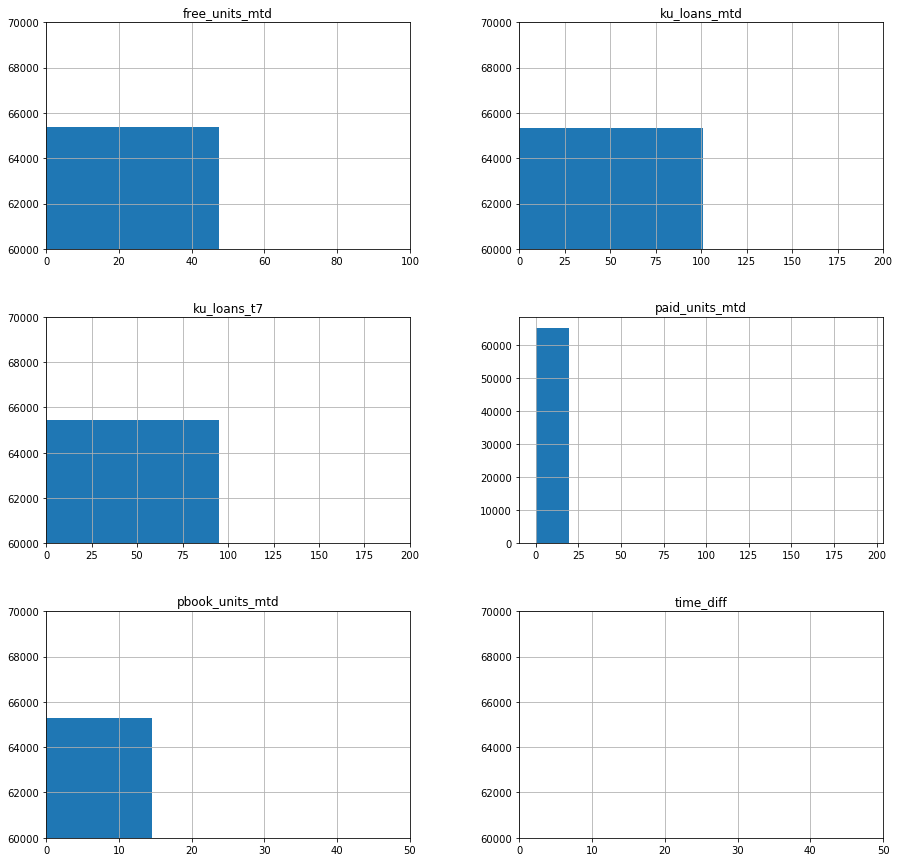

In [41]:
ax_list=pd.DataFrame.hist(x,['paid_units_mtd','ku_loans_t7','ku_loans_mtd','free_units_mtd','pbook_units_mtd','time_diff'],figsize =(15,15))
ax_list[0][0].set_xlim((0,100))
ax_list[0][0].set_ylim((60000,70000))
ax_list[0][1].set_xlim((0,200))
ax_list[0][1].set_ylim((60000,70000))
ax_list[1][0].set_xlim((0,200))
ax_list[1][0].set_ylim((60000,70000))
ax_list[1][1].set_xlim((0,20))
ax_list[2][0].set_xlim((0,50))
ax_list[2][0].set_ylim((60000,70000))
ax_list[2][1].set_xlim((0,50))
ax_list[2][1].set_ylim((60000,70000))

# I don't see anything skewed

In [261]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

df = x[(x.status == 'PAID ACTIVE') | (x.status == 'PAID CANCELLED')]
df.head(5)
# target, features = dmatrices('status ~ paid_units_mtd + ku_loans_mtd + free_units_mtd + pbook_units_mtd + num_active',
#                   df, return_type="dataframe")
target, features = dmatrices('status ~ ku_loans_mtd + ku_loans_t7 + time_diff + num_active + paid_units_mtd + free_units_mtd + ku_loans_mtd_june + ku_loans_t7_june + free_units_mtd_june + paid_units_mtd_june + ku_loans_mtd_may + ku_loans_t7_may + free_units_mtd_may + paid_units_mtd_may + ku_loans_mtd_apr + ku_loans_t7_apr + free_units_mtd_apr + paid_units_mtd_apr',
                  df, return_type="dataframe")
print features.columns
features.head(5)
print target.head()

#Set 1 to indicte customer churn, 0 otherwise
target['status'] = target['status[PAID CANCELLED]']
target = target['status']
# make it a 1d array
target = np.ravel(target)
print target.size

#Split into training and test sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=0)

# instantiate a logistic regression model, and fit with features and target
# model = LogisticRegression()
features_train.head(50)

Index([u'Intercept', u'ku_loans_mtd', u'ku_loans_t7', u'time_diff',
       u'num_active', u'paid_units_mtd', u'free_units_mtd',
       u'ku_loans_mtd_june', u'ku_loans_t7_june', u'free_units_mtd_june',
       u'paid_units_mtd_june', u'ku_loans_mtd_may', u'ku_loans_t7_may',
       u'free_units_mtd_may', u'paid_units_mtd_may', u'ku_loans_mtd_apr',
       u'ku_loans_t7_apr', u'free_units_mtd_apr', u'paid_units_mtd_apr'],
      dtype='object')
                                                                  status[PAID ACTIVE]  \
customer_id                                                                             
00012d5c5b3caba6486bf760f154a1a1310603a87a233982f19365ed4af4b60f  0.0                   
000151374577dd6fe194237e23627f83541bcc39926089d7f63bc041c7fafe67  0.0                   
00015215c16e4586578b42c2ee8535cbcec8e93bf2b62c78dfcbc059573d58b1  1.0                   
000152eaa0928969c1da93e930e2944698e21594729f6ae7182e8cda46233c46  0.0                   
0001d4efe1974e3d822ebe

,Intercept,ku_loans_mtd,ku_loans_t7,time_diff,num_active,paid_units_mtd,free_units_mtd,ku_loans_mtd_june,ku_loans_t7_june,free_units_mtd_june,paid_units_mtd_june,ku_loans_mtd_may,ku_loans_t7_may,free_units_mtd_may,paid_units_mtd_may,ku_loans_mtd_apr,ku_loans_t7_apr,free_units_mtd_apr,paid_units_mtd_apr
customer_id,,,,,,,,,,,,,,,,,,,
2ce682bd1642307bb91306c944bef51c350eb4c20a723cbaf3529829c0bb27cb,1.0,0.001984,0.000000,0.000000,0.016393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1ff37d52bb9e3ef8122a3634a1ec28af248385338fc12f3bc1477865e9a93355,1.0,0.002976,0.000000,0.000000,0.032787,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2ec6fd36280422c49e34d04c57c0b7a0a4fe170cbbca2288fd67572d83069cff,1.0,0.000000,0.000000,0.000000,0.016393,0.000000,0.000000,0.003165,0.000000,0.002903,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
762e68d0e10dde1d19b8e329da229a99e24dbfd28970174d9bf782c5719d33ce,1.0,0.000000,0.000000,0.659033,0.081967,0.010309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20d52a71763d07e9f46c107994239996de3aa57de9f19338af150033aa3eaf72,1.0,0.000000,0.000000,0.027990,0.180328,0.000000,0.000000,0.001055,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.001603,0.000000,0.000000,0.000000
ad9145d16741a4eb079c5a97c3ea07caa84018d463be3343be9bbf51af45a50d,1.0,0.000000,0.000000,0.480916,0.049180,0.005155,0.000000,0.007384,0.000000,0.000000,0.000000,0.007,0.016129,0.000000,0.010152,0.017628,0.021672,0.000000,0.000000
a6f91d7355925e1018b7f24a942d52deee84149dacf7f61e93277393bcc6ac75,1.0,0.011905,0.004219,0.127226,0.016393,0.000000,0.006329,0.009494,0.003484,0.000000,0.000000,0.008,0.005376,0.000000,0.000000,0.019231,0.006192,0.000000,0.000000
1a8b01668ba56ad8c0e9ff20fd773372108eb4c64948ef8979eb3d58c6d234d7,1.0,0.000000,0.000000,0.000000,0.049180,0.000000,0.000000,0.000000,0.000000,0.000000,0.007299,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23a640f707cfff09214a077d0caea8ad65b14fc851d0166f88984659981e2b79,1.0,0.004960,0.005274,0.000000,0.000000,0.000000,0.000000,0.006329,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.050761,0.000000,0.000000,0.000000,0.000000


In [262]:
from sklearn.grid_search import GridSearchCV

from sklearn.metrics import fbeta_score, make_scorer

# from sklearn import svm

from sklearn.ensemble import RandomForestClassifier

# # TODO: Initialize the classifier
# clf = DecisionTreeClassifier(random_state=0)

# # TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# # HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
# parameters = {'criterion': ["gini", "entropy"], 'max_features': ["auto", "sqrt","log2",None]}
# clf = GridSearchCV(svr, parameters,cv=5)

# TODO: Make an fbeta_score scoring object using make_scorer()
# scorer = make_scorer(fbeta_score, beta=0.5)
def custom_auc(ground_truth, predictions):
     # I need only one column of predictions["0" and "1"]. You can get an error here
     # while trying to return both columns at once
     fpr, tpr, _ = metrics.roc_curve(ground_truth, predictions[:, 1], pos_label=1)    
     return metrics.auc(fpr, tpr)

# to be standart sklearn's scorer        
# scorer = make_scorer(custom_auc, greater_is_better=True, needs_proba=False)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()

#Random Forest
max_depth = [i for i in range(5,15)]
min_samples_split = [i for i in range(10,20)]
n_estimators = [128]
parameters = {'max_depth':max_depth,'min_samples_split':min_samples_split,'n_estimators':n_estimators}
RFC=RandomForestClassifier()
grid_obj = GridSearchCV(RFC, parameters,cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(features_train,target_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

print grid_fit.best_params_ 

# Make predictions using the unoptimized and model
predicted = (best_clf.fit(features_train, target_train)).predict(features_test)
# predicted = best_clf.predict(features_test)


# model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
#                         algorithm="SAMME",
#                         n_estimators=20)
# model = model.fit(features_train, target_train)

# # predict the outcome for the test features
# predicted = model.predict(features_test)
print predicted

{'min_samples_split': 12, 'n_estimators': 128, 'max_depth': 14}
[ 0.  0.  0. ...,  0.  0.  0.]


In [263]:
# Check to see if it identifies anyone as churning
predicted = (best_clf.fit(features_train, target_train)).predict(features_test)
predicted.size
np.sum(predicted)

probs = best_clf.predict_proba(features_test)
print probs

print metrics.accuracy_score(target_test, predicted)
# The metric we use in leaderboard
print metrics.roc_auc_score(target_test, probs[:, 1])

print metrics.confusion_matrix(target_test, predicted)
print metrics.classification_report(target_test, predicted)

print predicted

[[ 0.83788707  0.16211293]
 [ 0.79550581  0.20449419]
 [ 0.93966296  0.06033704]
 ..., 
 [ 0.78235677  0.21764323]
 [ 0.8589065   0.1410935 ]
 [ 0.79887084  0.20112916]]
0.812353719345
0.753573471187
[[15712   191]
 [ 3497   254]]
             precision    recall  f1-score   support

        0.0       0.82      0.99      0.89     15903
        1.0       0.57      0.07      0.12      3751

avg / total       0.77      0.81      0.75     19654

[ 0.  0.  0. ...,  0.  0.  0.]


In [264]:
testdf = pd.read_csv('public_test_set.csv')

testdf.rename(columns={'Id': 'customer_id'}, inplace=True)
testdf.index = testdf.customer_id
testdf = testdf.drop('customer_id', axis=1)
testdf.head(5)
print testdf.shape


(67588, 0)


In [270]:
testfeatures = get_customer_activity_features('2017-08-31')
testfeatures.index = testfeatures.customer_id
testfeatures = testfeatures.drop('customer_id', axis=1)
print "activity features"
print testfeatures.shape
y = get_customer_activity_features('2017-07-31')
y.index = y.customer_id
y = y.drop('customer_id', axis=1)

y.rename(columns={'paid_units_mtd': 'paid_units_mtd_june', 'ku_loans_t7': 'ku_loans_t7_june', 'ku_loans_mtd': 'ku_loans_mtd_june', 'free_units_mtd': 'free_units_mtd_june', 'pbook_units_mtd': 'pbook_units_mtd_june'}, inplace=True)

print "activity features"
print testfeatures.shape
print y.shape
testfeatures = pd.merge(testfeatures, y , left_index=True, right_index=True, how="outer")


print testfeatures.shape
z = get_customer_activity_features('2017-06-30')
z.index = z.customer_id
z = z.drop('customer_id', axis=1)

z.rename(columns={'paid_units_mtd': 'paid_units_mtd_may', 'ku_loans_t7': 'ku_loans_t7_may', 'ku_loans_mtd': 'ku_loans_mtd_may', 'free_units_mtd': 'free_units_mtd_may', 'pbook_units_mtd': 'pbook_units_mtd_may'}, inplace=True)

print "activity features"
print testfeatures.shape
print z.shape
testfeatures = pd.merge(testfeatures, z , left_index=True, right_index=True, how="outer")

y = get_customer_activity_features('2017-05-31')
y.index = y.customer_id
y = y.drop('customer_id', axis=1)

y.rename(columns={'paid_units_mtd': 'paid_units_mtd_apr', 'ku_loans_t7': 'ku_loans_t7_apr', 'ku_loans_mtd': 'ku_loans_mtd_apr', 'free_units_mtd': 'free_units_mtd_apr', 'pbook_units_mtd': 'pbook_units_mtd_apr'}, inplace=True)

print "activity features"
print testfeatures.shape
print y.shape
testfeatures = pd.merge(testfeatures, y , left_index=True, right_index=True, how="outer")

print testfeatures.shape

activity features
(141911, 5)
activity features
(141911, 5)
(135985, 5)
(144210, 10)
activity features
(144210, 10)
(128396, 5)
activity features
(145394, 15)
(120883, 5)
(145489, 20)


In [273]:
status = get_customer_status('2017-09-30', '2017-08-31')
status.head(5)
# testfeatures =  testfeatures[testfeatures.index.isin(status.index)]
# testfeatures['time_diff'] = status[status.index.isin(testfeatures.index)]['time_diff']
# x['num_days'] = status[status.index.isin(x.index)]['time_diff']
df1 = status[['time_diff']]

print "status features"
print testfeatures.shape
print df1.shape
testfeatures = pd.merge(testfeatures,df1 , left_index=True, right_index=True, how = "left")

print testfeatures.shape

device_counts = get_customer_device_features('2017-08-31')
#x['active_android'] = device_counts[device_counts.index.isin(x.index)]
testfeatures['num_active'] = device_counts[device_counts.index.isin(testfeatures.index)]
print testfeatures.shape

testfeatures.head(5)
# write_to_s3(x, 'ml-hack-subs-data', 'prepared-dataset-2017-08-31.csv')

C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


status features
(145489, 20)
(67588, 1)
(145489, 21)
(145489, 22)


,paid_units_mtd,ku_loans_t7,ku_loans_mtd,free_units_mtd,pbook_units_mtd,paid_units_mtd_june,ku_loans_t7_june,ku_loans_mtd_june,free_units_mtd_june,pbook_units_mtd_june,...,ku_loans_mtd_may,free_units_mtd_may,pbook_units_mtd_may,paid_units_mtd_apr,ku_loans_t7_apr,ku_loans_mtd_apr,free_units_mtd_apr,pbook_units_mtd_apr,time_diff,num_active
customer_id,,,,,,,,,,,,,,,,,,,,,
00006cbd025f7b0b3f894b319efccde84f1b059bf7b76f0a44de15e6fd19e82e,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.002183,0.0,0.0,0.0,0.0,NaN,2.0
0000dfb1ac7e6ffb2e8f0f4e14271afa87cf0c5cddc030916709d13ef1763d76,0.01676,0.0,0.002587,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3.0
0000e2aee8f9a5f294b1d8f765c8848e00eb051cc4faaa3ab4eb75c879dbcb7b,0.00000,0.0,0.000000,0.000000,0.0,0.005155,0.0,0.0,0.0,0.006849,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,4.0
0000f6dbd168a7b51a238b6a2ffbc66f7c097bda5326d48ac076e207a89b5ff1,0.00000,0.0,0.010349,0.006477,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
000112ee1dbd72cede2d7e0b62eb010ba97bb6ec12eac83328b545f11c434f2b,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,NaN,2.0


In [274]:
testfeatures.fillna(0, inplace=True)
testfeatures = getNormalizedFeatures(testfeatures)
print testfeatures.shape
testfeatures
print testfeatures.shape
print testdf.shape
testfeaturesfinal = pd.merge(testfeatures, testdf, left_index=True, right_index=True, how="right")
testfeaturesfinal.head(5)
print testfeaturesfinal.shape
# target, features = dmatrices('status ~ paid_units_mtd + ku_loans_mtd + free_units_mtd + pbook_units_mtd + num_active',
#                   df, return_type="dataframe")
testfinalfeatures = testfeaturesfinal[['ku_loans_mtd', 'ku_loans_t7', 'time_diff', 'num_active', 'paid_units_mtd', 'free_units_mtd', 'ku_loans_mtd_june', 'ku_loans_t7_june', 'free_units_mtd_june', 'paid_units_mtd_june', 'ku_loans_mtd_may', 'ku_loans_t7_may', 'free_units_mtd_may', 'paid_units_mtd_may', 'ku_loans_mtd_apr', 'ku_loans_t7_apr', 'free_units_mtd_apr', 'paid_units_mtd_apr']]
# target, testfinalfeatures = dmatrices('status ~ ku_loans_mtd + ku_loans_t7 + time_diff + num_active + paid_units_mtd + free_units_mtd + ku_loans_mtd_june + ku_loans_t7_june + free_units_mtd_june + ku_loans_mtd_may + ku_loans_t7_may + free_units_mtd_may',
#                   df, return_type="dataframe")

print testfinalfeatures.shape
testfinalfeatures.fillna(0, inplace=True)
# testfinalfeatures = removeOutliers(testfinalfeatures)
print testfinalfeatures.shape
Intercept = [1.0]*67588
se = pd.Series(Intercept)
testfinalfeatures['Intercept'] = se.values

print testfinalfeatures.shape
predicted = best_clf.predict(testfinalfeatures)
print predicted.shape


(145489, 22)
(145489, 22)
(67588, 0)
(67588, 22)
(67588, 18)
(67588, 18)


C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(67588, 19)
(67588L,)


In [275]:
se = pd.Series(predicted)
print testfinalfeatures.shape
testfinalfeatures['ku_status'] = se.values
print testfinalfeatures.shape
outputpd = testfinalfeatures[['ku_status']]
outputpd.ku_status = outputpd.ku_status.astype(int)
outputpd.head(10)
outputpd.index.names = ['ID']
outputpd.to_csv(r'C:\Users\choppak\Desktop\Lstudy\MLND\KU prediction\output_6.csv', sep=',', mode='a')
outputpd.shape

# outputdf = pd.DataFrame(testfeatures['customer_id'],predicted)
# outputdf .head(5)

(67588, 19)
(67588, 20)


C:\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(67588, 1)

In [ ]:
testdf =  testdf[testdf.index.isin(testfinalfeatures.index)]
testdf['status'] = status[status.index.isin(testdf.index)]['ku_status']

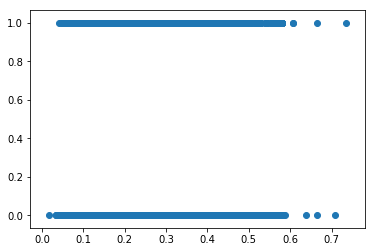

In [11]:
corr = pd.DataFrame()
corr['prob'] = probs[:,1]
corr['status'] = target_test
corr.sort_values(by='status').tail()
plt.scatter(corr['prob'], corr['status'])

In [ ]:
device_counts['18272f7fb12370c0a3f3f7b199d5d691be231ac491257c4c342611fe5998643b']